- Reference
  - https://www.bigdata-navi.com/aidrops/2611/

エポック数を増やして変化を確認

In [8]:
import os
import numpy as np
import datetime
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score

### モデル定義

In [2]:
class Block(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        channel = channel_out // 4

        # 1x1 の畳み込み
        self.conv1 = nn.Conv2d(channel_in, channel,
                               kernel_size=(1, 1))
        self.bn1 = nn.BatchNorm2d(channel)
        self.relu1 = nn.ReLU()

        # 3x3 の畳み込み
        self.conv2 = nn.Conv2d(channel, channel,
                               kernel_size=(3, 3),
                               padding=1)
        self.bn2 = nn.BatchNorm2d(channel)
        self.relu2 = nn.ReLU()

        # 1x1 の畳み込み
        self.conv3 = nn.Conv2d(channel, channel_out,
                               kernel_size=(1, 1),
                               padding=0)
        self.bn3 = nn.BatchNorm2d(channel_out)

        # skip connection用のチャネル数調整        
        self.shortcut = self._shortcut(channel_in, channel_out)
        
        self.relu3 = nn.ReLU()

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        y = self.relu3(h + shortcut)  # skip connection
        return y

    def _shortcut(self, channel_in, channel_out):
        if channel_in != channel_out:
            return self._projection(channel_in, channel_out)
        else:
            return lambda x: x

    def _projection(self, channel_in, channel_out):
        return nn.Conv2d(channel_in, channel_out,
                         kernel_size=(1, 1),
                         padding=0)

In [3]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self,
                 device='cpu'):
        super().__init__()

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:]).view(-1, x.size(1))

In [4]:
class ResNet50(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64,
                               kernel_size=(7, 7),
                               stride=(2, 2),
                               padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3),
                                  stride=(2, 2),
                                  padding=1)

        # Block 1
        self.block0 = self._building_block(256, channel_in=64)

        self.block1 = nn.ModuleList([
            self._building_block(256) for _ in range(2)
        ])
        self.conv2 = nn.Conv2d(256, 512,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 2
        self.block2 = nn.ModuleList([
            self._building_block(512) for _ in range(4)
        ])
        self.conv3 = nn.Conv2d(512, 1024,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 3
        self.block3 = nn.ModuleList([
            self._building_block(1024) for _ in range(6)
        ])
        self.conv4 = nn.Conv2d(1024, 2048,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 4
        self.block4 = nn.ModuleList([
            self._building_block(2048) for _ in range(3)
        ])
        self.avg_pool = GlobalAvgPool2d()  # TODO: GlobalAvgPool2d
        self.fc = nn.Linear(2048, 1000)
        self.out = nn.Linear(1000, output_dim)

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.block0(h)

        for block in self.block1:
            h = block(h)

        h = self.conv2(h)

        for block in self.block2:
            h = block(h)

        h = self.conv3(h)

        for block in self.block3:
            h = block(h)

        h = self.conv4(h)

        for block in self.block4:
            h = block(h)

        h = self.avg_pool(h)
        h = self.fc(h)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.log_softmax(h, dim=-1)

        return y

    def _building_block(self,
                        channel_out,
                        channel_in=None):
        if channel_in is None:
            channel_in = channel_out

        return Block(channel_in, channel_out)

### 学習

In [5]:
np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
root = os.path.join('data')

transform = transforms.Compose([transforms.ToTensor()])

mnist_train = torchvision.datasets.FashionMNIST(
    root=root, download=True, train=True, transform=transform)

mnist_test = torchvision.datasets.FashionMNIST(
    root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False)

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
model = ResNet50(10).to(device)

criterion = nn.NLLLoss()
optimizer = optimizers.Adam(model.parameters(), weight_decay=0.01)


def compute_loss(label, pred):
    return criterion(pred, label)

def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def test_step(x, t):
    model.eval()
    preds = model(x)
    loss = compute_loss(t, preds)
    return loss, preds

In [15]:
epochs = 20

history = pd.DataFrame({}, columns=['epoch', 'loss', 'acc'])


print(datetime.datetime.now().isoformat(), 'Start')

for epoch in range(epochs):

    train_loss = 0.
    test_loss = 0.
    test_acc = 0.

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, _ = train_step(x, t)
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    for (x, t) in test_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = test_step(x, t)
        test_loss += loss.item()
        test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(datetime.datetime.now().isoformat(),
          'Epoch: {}, Valid Cost: {:.3f}, Valid Acc: {:.3f}'.format(
              epoch+1, test_loss, test_acc))

    history = history.append({'epoch': epoch+1, 'loss': test_loss, 'acc': test_acc},
                             ignore_index=True)

print(datetime.datetime.now().isoformat(), 'End')

2020-08-20T09:32:54.710153 Start
2020-08-20T09:33:34.202954 Epoch: 1, Valid Cost: 0.538, Valid Acc: 0.819
2020-08-20T09:34:13.702669 Epoch: 2, Valid Cost: 0.435, Valid Acc: 0.853
2020-08-20T09:34:53.344417 Epoch: 3, Valid Cost: 0.462, Valid Acc: 0.834
2020-08-20T09:35:32.856048 Epoch: 4, Valid Cost: 0.516, Valid Acc: 0.821
2020-08-20T09:36:12.418855 Epoch: 5, Valid Cost: 0.437, Valid Acc: 0.850
2020-08-20T09:36:51.801339 Epoch: 6, Valid Cost: 0.405, Valid Acc: 0.862
2020-08-20T09:37:31.344793 Epoch: 7, Valid Cost: 0.481, Valid Acc: 0.847
2020-08-20T09:38:10.832524 Epoch: 8, Valid Cost: 0.366, Valid Acc: 0.877
2020-08-20T09:38:50.326510 Epoch: 9, Valid Cost: 0.411, Valid Acc: 0.868
2020-08-20T09:39:29.765097 Epoch: 10, Valid Cost: 0.465, Valid Acc: 0.838
2020-08-20T09:40:09.444178 Epoch: 11, Valid Cost: 0.416, Valid Acc: 0.858
2020-08-20T09:40:48.849942 Epoch: 12, Valid Cost: 0.357, Valid Acc: 0.878
2020-08-20T09:41:28.357181 Epoch: 13, Valid Cost: 0.357, Valid Acc: 0.878
2020-08-20T09:

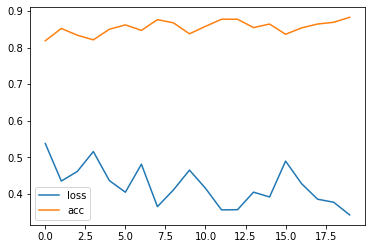

In [16]:
history[['loss', 'acc']].plot()